In [1]:
%load_ext autoreload
%autoreload 2

# NOTES

- [Topic Modeling with BERT](https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6)
- [sentence-transforrmers clustering](https://www.sbert.net/examples/applications/clustering/README.html)
  - [fast_clustering](https://github.com/UKPLab/sentence-transformers/blob/master/examples/applications/clustering/fast_clustering.py)
    - 50k sentences in less than 5 seconds). 
    - In a large list of sentences it searches for local communities: A local community is a set of highly similar sentences.

In [1]:
from rdkit import RDLogger
import pandas as pd
from thesis_work.utils import get_largest_fragment_from_smiles
from thesis_work.chemberta.model_descriptors import gen_embeddings
from thesis_work.chemberta.model_descriptors import (
    get_model_descriptors,
    initialize_model_tokenizer,
)
from thesis_work.utils import get_ecfp_descriptor
from thesis_work.data import load_data, load_interacted_compounds

import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import DataStructs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
from thesis_work.clustering import get_efcp_similarity_matrix, get_efcp_distance_matrix


# Silence RDKit warnings
logger = RDLogger.logger()
logger.setLevel(RDLogger.CRITICAL)


## print numpy array more beautifully
# np.set_printoptions(suppress=True)
# np.set_printoptions(precision=3)

random_state = 42

Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/ilker/miniconda3/envs/thesis-work/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [3]:
protein_type = "kinase"
# protein_type = "protease"
# protein_type = "gpcr"

# model_name = "DeepChem/ChemBERTa-77M-MLM"
model_name = "DeepChem/ChemBERTa-77M-MTR"

## Data


### Ours

In [3]:
data = load_data(protein_type=protein_type)
smiles = data["text"].tolist()
data

,text,labels
0,O=C(Cc1cccc2ccccc12)Nc1n[nH]c2ccc(N3CCCS3(=O)=...,1
1,COC(=O)NC[C@@H](NC(=O)c1ccc(-c2nc(C3CCOCC3)cnc...,1
2,COc1ccccc1Nc1cc(Oc2cc(C)c(C)nc2-c2ccccn2)ccn1,1
3,O=C(/C=C/CN1CCCC1)N1CCOc2cc3ncnc(Nc4ccc(F)c(Cl...,1
4,O=C(Nc1cccc(Nc2cc3c(=O)[nH][nH]c(=O)c3cc2Cl)c1...,1
...,...,...
66304,CS(=O)(=O)c1ccccc1Nc1cccn2nc(Nc3ccc(OCCN4CCCC4...,0
66305,CC(C)n1cc(C(=O)c2cncc(NC(=O)c3ccc4nnnn4c3)c2)c...,0
66306,CNC(=O)c1ccc2[nH]nc(-c3cccc(C(=O)NCc4cccc5cccc...,0
66307,NC(=O)c1c(NC(=O)COC(=O)CCC(=O)c2ccc(Cl)cc2)sc2...,0


### Ours - Mixed Interactive

In [2]:
each_sample_size = 2000

kinase_interact = load_interacted_compounds(protein_type="kinase")[:each_sample_size]
kinase_interact["labels"] = 0

protease_interact = load_interacted_compounds(protein_type="protease")[
    :each_sample_size
]
protease_interact["labels"] = 1

gpcr_interact = load_interacted_compounds(protein_type="gpcr")[:each_sample_size]
gpcr_interact["labels"] = 2


data = pd.concat(
    [kinase_interact, protease_interact, gpcr_interact], axis=0, ignore_index=True
)
smiles = data["text"].tolist()
data

,text,labels
0,O=C(Cc1cccc2ccccc12)Nc1n[nH]c2ccc(N3CCCS3(=O)=...,0
1,COC(=O)NC[C@@H](NC(=O)c1ccc(-c2nc(C3CCOCC3)cnc...,0
2,COc1ccccc1Nc1cc(Oc2cc(C)c(C)nc2-c2ccccn2)ccn1,0
3,O=C(/C=C/CN1CCCC1)N1CCOc2cc3ncnc(Nc4ccc(F)c(Cl...,0
4,O=C(Nc1cccc(Nc2cc3c(=O)[nH][nH]c(=O)c3cc2Cl)c1...,0
...,...,...
5995,CC1=CCC[C@H]1NC(=O)Nc1ccc(Cl)c(S(=O)(=O)C2(C)C...,2
5996,COc1cccc2c1CC[C@H]1CN(CCn3c(=O)[nH]c4nccnc4c3=...,2
5997,O=C(O)c1cc(NC(=O)c2cnccn2)cc(-c2ccc(C3CCNCC3)c...,2
5998,COc1ccc(-c2cc(C(N)=O)nc3cc(CN4C(=O)CCC4=O)ccc2...,2


### BBBP

In [5]:
# Read in data from MoleculeNet
data = pd.read_csv("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/BBBP.csv")

# Clean up columnn names so they are easier to interpret
data = (
    data[["smiles", "p_np", "name"]]
    .reset_index(drop=True)
    .rename({"smiles": "text", "p_np": "labels"}, axis=1)
)

# Remove extra fragments in SMILES (typically salts, which are irrelevant to BBB permeability)
data["text"] = data["text"].apply(get_largest_fragment_from_smiles).dropna().astype(str)

# convert to str list
smiles = data["text"].tolist()

data

,text,labels,name
0,CC(C)NCC(O)COc1cccc2ccccc12,1,Propanolol
1,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,1,Terbutylchlorambucil
2,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,1,40730
3,CC(=O)NCCCOc1cccc(CN2CCCCC2)c1,1,24
4,Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H...,1,cloxacillin
...,...,...,...
2045,O=c1[nH]c2cc(Cl)c(Cl)c([N+](=O)[O-])c2[nH]c1=O,1,licostinel
2046,C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc...,1,ademetionine(adenosyl-methionine)
2047,CC(Cc1ccccc1)n1cc([N-]C(=O)Nc2ccccc2)[o+]n1,1,mesocarb
2048,CCc1c(C)[n+]([NH-])c(-c2ccc(OC)c(OC)c2)c2cc(OC...,1,tofisoline


## Model Embeddings


### bert_loves_chemistry version


In [7]:
model, tokenizer = initialize_model_tokenizer(model_name=model_name)

bpe_sentence_embeddings = gen_embeddings(
    model=model, tokenizer=tokenizer, smiles=smiles
)
bpe_sentence_embeddings.shape

Some weights of the model checkpoint at DeepChem/ChemBERTa-77M-MLM were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MLM and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

### my version

- simpletransformers
- selformer


In [ ]:
model, tokenizer = initialize_model_tokenizer(model_name=model_name)
data["vector"] = get_model_descriptors(
    smiles_series=data["text"],
    model_name=model_name,
    method="simpletransformers",
)

bpe_sentence_embeddings = data["vector"].tolist()

## ECFP Embeddings

- ECFP4 - 1024
- ECFP6 - 2048


In [3]:
# Generate ECFP descriptors
ecfps = [
    get_ecfp_descriptor(smiles_str=smiles_str, nBits=2048) for smiles_str in smiles
]

n_ecfps = len(ecfps)

## K-Means

- Silhouette score:  0.08960959422213507 ??

In [ ]:
similarity_matrix = get_efcp_similarity_matrix(smiles_list=smiles, method="fast")

## For checking the slow method
# similarity_matrix_slow = get_efcp_similarity_matrix(smiles_list=smiles, method="slow")
# np.array_equal(similarity_matrix, similarity_matrix_slow)
# np.allclose(similarity_matrix, similarity_matrix_slow, rtol=0, atol=0.2)

num_clusters = 3

kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(similarity_matrix)

cluster_labels = kmeans.labels_

# Evaluate clustering result
score = silhouette_score(similarity_matrix, cluster_labels)

print("Silhouette score: ", score)
print("Cluster assignments: ", cluster_labels)

In [ ]:
for cluster_id in range(num_clusters):
    print(f"Cluster {cluster_id + 1}:")
    cluster_text_indices = np.where(cluster_labels == cluster_id)[0]
    for index in cluster_text_indices:
        print(smiles[index])
    print("\n")

## Butina clustering

- Silhouette Score:  0.0007162032683292052 ??

In [8]:
# TODO: Find out correct way to use Butina clustering
from rdkit.ML.Cluster import Butina

distances = []
for i in range(len(ecfps)):
    sims = DataStructs.BulkTanimotoSimilarity(ecfps[i], ecfps[:i])
    distances.extend([1 - x for x in sims])

# NOTE: Probably nott the correct way.s
# distances = get_efcp_distance_matrix(smiles_list=smiles, method="fast")

threshold = 0.2
clusters = Butina.ClusterData(distances, n_ecfps, threshold, isDistData=True)

# Convert the clusters into labels for the silhouette score
cluster_labels = np.zeros(n_ecfps)
for i, cluster in enumerate(clusters):
    for mol in cluster:
        cluster_labels[mol] = i


# Compute the silhouette score
silhouette_score = silhouette_score(
    distances.tolist(), cluster_labels, metric="jaccard"
)
# silhouette_score = silhouette_score(ecfps, cluster_labels, metric="jaccard")

print("Silhouette Score: ", silhouette_score)
print("Cluster assignments: ", cluster_labels)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## UMAP

- [bert-loves-chemisrty example](https://github.com/seyonechithrananda/bert-loves-chemistry/blob/master/chemberta/visualization/ChemBERTA_dimensionaliy_reduction_BBBP.ipynb)

### TIMES:
- Kinase (68k): 3 min 20s
  - n_neighbors=50, n_components=2


In [8]:
# NOTE: Default value is 15
n_neighbors = 15

n_components = 2

In [9]:
%%time
import umap

# embed with umap
umap_model = umap.UMAP(
    metric="jaccard",
    # metric="cosine",
    n_neighbors=n_neighbors,
    n_components=n_components,
    low_memory=False,
    min_dist=0.001,
    random_state=random_state,
)
X_umap = umap_model.fit_transform(bpe_sentence_embeddings)

/home/ilker/miniconda3/envs/thesis-work/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ilker/miniconda3/envs/thesis-work/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ilker/miniconda3/envs/thesis-work/lib/python3.10/site-

CPU times: user 30.7 s, sys: 1.47 s, total: 32.1 s
Wall time: 29.9 s


In [10]:
umap_data = pd.DataFrame(data["labels"])
umap_data["UMAP_X"], umap_data["UMAP_Y"] = X_umap[:, 0], X_umap[:, 1]

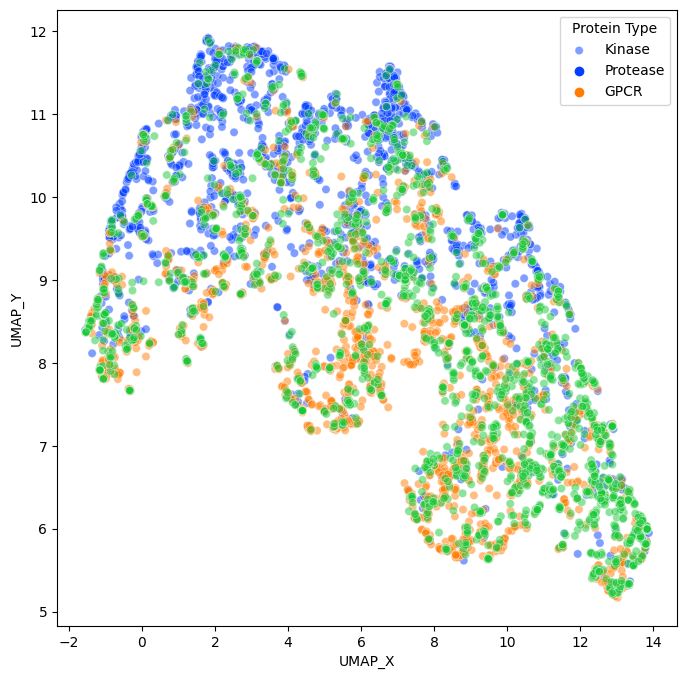

In [11]:
# palette = sns.color_palette(["hotpink", "dodgerblue"])
palette = sns.color_palette("bright", 3)

# methods = ["BPE_UMAP", "st_UMAP", "ecfp_UMAP"]
methods = ["UMAP"]

for method in methods:
    plt.figure(figsize=(8, 8))
    sns_plt = sns.scatterplot(
        data=umap_data,
        x=f"{method}_X",
        y=f"{method}_Y",
        hue="labels",
        alpha=0.5,
        palette=palette,
    )
    # plt.title(f"{method} Embedding of the Dataset")
    plt.legend(
        title="Protein Type", loc="upper right", labels=["Kinase", "Protease", "GPCR"]
    )
    plt.show()

## QPI


In [ ]:
# FIXME: Not working
def quality_partition_index(clusters, distances):
    intra_cluster_distances = [
        min([distances[i][j] for j in cluster]) for i, cluster in enumerate(clusters)
    ]
    min_intra_cluster_distance = min(intra_cluster_distances)
    max_inter_cluster_distance = max(
        [distances[i][j] for i in range(len(distances)) for j in range(i)]
    )

    return min_intra_cluster_distance / max_inter_cluster_distance


qpi = quality_partition_index(clusters, distances)
print("Quality Partition Index: ", qpi)